### Convolutional neuural network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from dataset import mnist
from util import (
    get_torch_size_string,
    print_model_parameters,
    print_model_layers,
    model_train,
    model_eval,
    model_test
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Hyperparameters

In [2]:
device      = 'cpu' # cpu / mps
n_epoch     = 20
batch_size  = 128
print_every = 1
print ("Ready.")

Ready.


### Dataset

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready.")

MNIST ready.


### Model

In [4]:
class ConvNetClass(nn.Module):
    def __init__(
        self,
        name        = 'cnn',
        x_dim       = (1,28,28),
        k_size      = (3,3),
        stride      = (1,1),
        padding     = (1,1),
        max_pooling = (2,2),
        c_dim_list  = (32,64), # conv channel
        h_dim_list  = (32,16), # dense hidden
        y_dim       = 10,
        actv        = nn.ReLU(),
        p_drop      = 0.2
    ):
        """
            Initialize CNN
        """
        super(ConvNetClass,self).__init__()
        self.name        = name
        self.x_dim       = x_dim
        self.k_size      = k_size
        self.stride      = stride
        self.padding     = padding
        self.max_pooling = max_pooling
        self.c_dim_list  = c_dim_list
        self.h_dim_list  = h_dim_list
        self.y_dim       = y_dim
        self.actv        = actv
        self.p_drop      = p_drop
        
        # Declare layers
        
        # Conv part
        self.layer_list = []
        c_dim_prev = self.x_dim[0]
        for c_dim in self.c_dim_list:
            # conv -> batchnorm -> actv -> maxpool -> dropout
            self.layer_list.append(
                nn.Conv2d(
                    in_channels  = c_dim_prev,
                    out_channels = c_dim,
                    kernel_size  = self.k_size,
                    stride       = self.stride,
                    padding      = self.padding
                )
            )
            self.layer_list.append(nn.BatchNorm2d(num_features=c_dim))
            self.layer_list.append(self.actv)
            self.layer_list.append(
                nn.MaxPool2d(
                    kernel_size = self.max_pooling, 
                    stride      = self.max_pooling
                )
            )
            self.layer_list.append(nn.Dropout2d(p=self.p_drop))
            c_dim_prev = c_dim
            
        # Dense part
        self.layer_list.append(nn.Flatten())
        h_dim_prev = c_dim_prev*\
            (self.x_dim[1]//(2**len(self.c_dim_list)))*\
            (self.x_dim[2]//(2**len(self.c_dim_list)))
        for h_dim in h_dim_list:
            # dense -> batchnorm -> actv -> dropout
            self.layer_list.append(nn.Linear(h_dim_prev,h_dim))
            self.layer_list.append(nn.BatchNorm1d(num_features=h_dim))
            self.layer_list.append(self.actv)
            self.layer_list.append(nn.Dropout1d(p=self.p_drop))
            h_dim_prev = h_dim
        self.layer_list.append(nn.Linear(h_dim_prev,self.y_dim))
        
        # Define net
        self.net = nn.Sequential()
        self.layer_names = []
        for l_idx,layer in enumerate(self.layer_list):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
            self.net.add_module(layer_name,layer)
        
        # Initialize parameters
        self.init_param(VERBOSE=False)
        
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm1d) or isinstance(m,nn.BatchNorm2d): 
                # init BN
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
                
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for idx,layer in enumerate(self.net):
            x = layer(x)
            intermediate_output_list.append(x)
        # Final output
        final_output = x
        return final_output,intermediate_output_list
    
print ("Ready.")        

Ready.


In [5]:
cnn = ConvNetClass(
    name        = 'cnn',
    x_dim       = (1,28,28),
    k_size      = (3,3),
    stride      = (1,1),
    padding     = (1,1),
    max_pooling = (2,2),
    c_dim_list  = (32,64), # conv channel
    h_dim_list  = (32,16), # dense hidden
    y_dim       = 10,
    actv        = nn.Mish(),
    p_drop      = 0.35
).to(device)
loss = nn.CrossEntropyLoss()
optm = th.optim.Adam(cnn.parameters(),lr=1e-3)
print ("Ready.")

Ready.


### Print model parameters

In [6]:
print_model_parameters(cnn)

[ 0] parameter:[       net.conv2d_00.weight] shape:[    32x1x3x3] numel:[       288]
[ 1] parameter:[         net.conv2d_00.bias] shape:[          32] numel:[        32]
[ 2] parameter:[  net.batchnorm2d_01.weight] shape:[          32] numel:[        32]
[ 3] parameter:[    net.batchnorm2d_01.bias] shape:[          32] numel:[        32]
[ 4] parameter:[       net.conv2d_05.weight] shape:[   64x32x3x3] numel:[     18432]
[ 5] parameter:[         net.conv2d_05.bias] shape:[          64] numel:[        64]
[ 6] parameter:[  net.batchnorm2d_06.weight] shape:[          64] numel:[        64]
[ 7] parameter:[    net.batchnorm2d_06.bias] shape:[          64] numel:[        64]
[ 8] parameter:[       net.linear_11.weight] shape:[     32x3136] numel:[    100352]
[ 9] parameter:[         net.linear_11.bias] shape:[          32] numel:[        32]
[10] parameter:[  net.batchnorm1d_12.weight] shape:[          32] numel:[        32]
[11] parameter:[    net.batchnorm1d_12.bias] shape:[          32]

### Print model layers

In [7]:
x_torch = th.randn((16,)+cnn.x_dim).to(device)
print_model_layers(cnn,x_torch)

batch_size:[16]
[  ] layer:[          input] size:[    16x1x28x28]
[ 0] layer:[      conv2d_00] size:[   16x32x28x28] numel:[    401408]
[ 1] layer:[ batchnorm2d_01] size:[   16x32x28x28] numel:[    401408]
[ 2] layer:[        mish_02] size:[   16x32x28x28] numel:[    401408]
[ 3] layer:[   maxpool2d_03] size:[   16x32x14x14] numel:[    100352]
[ 4] layer:[   dropout2d_04] size:[   16x32x14x14] numel:[    100352]
[ 5] layer:[      conv2d_05] size:[   16x64x14x14] numel:[    200704]
[ 6] layer:[ batchnorm2d_06] size:[   16x64x14x14] numel:[    200704]
[ 7] layer:[        mish_07] size:[   16x64x14x14] numel:[    200704]
[ 8] layer:[   maxpool2d_08] size:[     16x64x7x7] numel:[     50176]
[ 9] layer:[   dropout2d_09] size:[     16x64x7x7] numel:[     50176]
[10] layer:[     flatten_10] size:[       16x3136] numel:[     50176]
[11] layer:[      linear_11] size:[         16x32] numel:[       512]
[12] layer:[ batchnorm1d_12] size:[         16x32] numel:[       512]
[13] layer:[        mis

### Train CNN

In [8]:
model_train(cnn,optm,loss,train_iter,test_iter,n_epoch,print_every,device)

epoch:[ 0/20] loss:[1.542] train_accr:[0.9695] test_accr:[0.9709].
epoch:[ 1/20] loss:[1.384] train_accr:[0.9802] test_accr:[0.9813].
epoch:[ 2/20] loss:[1.365] train_accr:[0.9842] test_accr:[0.9827].
epoch:[ 3/20] loss:[1.355] train_accr:[0.9863] test_accr:[0.9862].
epoch:[ 4/20] loss:[1.355] train_accr:[0.9879] test_accr:[0.9867].
epoch:[ 5/20] loss:[1.344] train_accr:[0.9898] test_accr:[0.9879].
epoch:[ 6/20] loss:[1.342] train_accr:[0.9908] test_accr:[0.9893].
epoch:[ 7/20] loss:[1.348] train_accr:[0.9922] test_accr:[0.9891].
epoch:[ 8/20] loss:[1.338] train_accr:[0.9922] test_accr:[0.9887].
epoch:[ 9/20] loss:[1.349] train_accr:[0.9926] test_accr:[0.9906].
epoch:[10/20] loss:[1.341] train_accr:[0.9926] test_accr:[0.9890].
epoch:[11/20] loss:[1.341] train_accr:[0.9938] test_accr:[0.9902].
epoch:[12/20] loss:[1.339] train_accr:[0.9944] test_accr:[0.9902].
epoch:[13/20] loss:[1.344] train_accr:[0.9946] test_accr:[0.9901].
epoch:[14/20] loss:[1.341] train_accr:[0.9943] test_accr:[0.99

### Test CNN

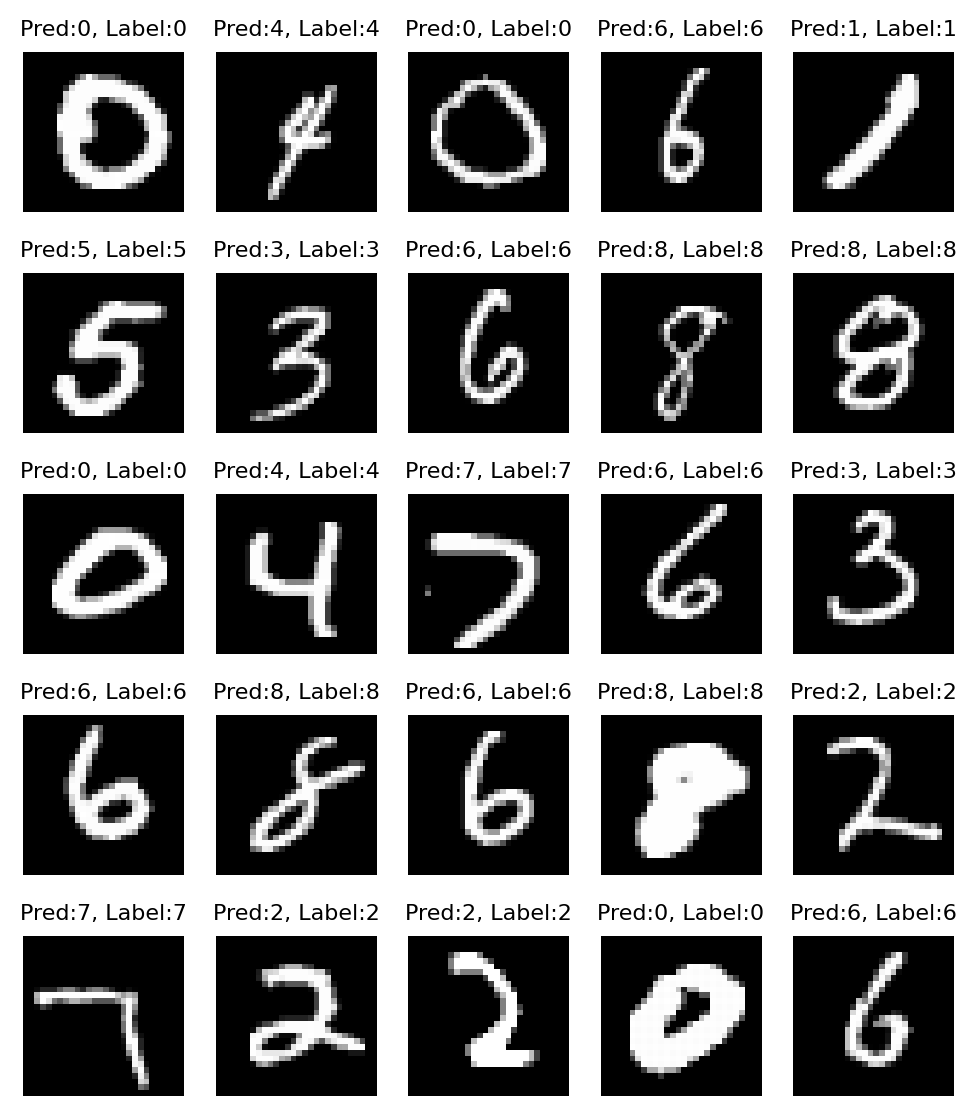

In [9]:
model_test(cnn,test_data,test_label,device)